# Machine Learning Project 
#### Forensic Glass Fragment Analysis using Classification 
---

*Ludek Cizinský (luci@itu.dk)*, *Lukas Rasocha (lukr@itu.dk)*, *Mika Senghaas (jsen@itu.dk)*

Lecturers: *Therese Graversen*, *Djordje Grbic*, *Payam Zahadat*

Deadline: *3rd of January 2022*

Last Modified: *24th of Novemeber 2021*

## Assignment Description
---
This project explores the possibility of using the elemental composition and refractive index to determine the origin of a very small glass fragment. This was studied by Evett and Spiehler (1987), who wrote in their paper:

```
Glass is a material which figures prominently in the investigation of crimes such as burglary and criminal damage in which it is common for a window to be smashed violently, either to gain access or as an act of vandalism. If a suspect is apprehended for such an offence then it is almost a routine matter to submit articles of his clothing to a forensic science laboratory so that a scientist may determine whether or not there is evidential material present.
Evett and Spiehler (1987)
```

The study by Evett and Spiehler (1987) is just one example of the many contributions to the field of forensic science that came out of the UK Forensic Science Service before it was closed in 2012. For this project, we use the data from their study, as found in (Dua and Graff, 2019), to investigate suitable classification techniques for determining the origin of a glass fragment.

## Environment Setup
---
This project uses Python libraries that are essential for the performed analysis. Make sure to have the dependencies listed in `requirements.txt` installed locally using the *Python Package Manager* `pip`. If installed, running the next code cell should install all relevant dependencies. Check documentation via the provided links:

- [*NumPy* Quickstart](https://numpy.org/doc/stable/user/quickstart.html)
- [*Matplotlib* Documentation](https://matplotlib.org/stable/tutorials/introductory/usage.html)
- [*Pandas* Documentation](https://pandas.pydata.org/docs/)
- [*Sklearn* Documentation](https://scikit-learn.org/stable/)

### Libraries

In [1]:
%%capture
!pip install -r requirements.txt

In [4]:
# python standard library
from time import time                                           # used for timing execution
from datetime import date, datetime                             # get current data and time
import json                                                     # read/ write json
import re                                                       # regex search 
import os                                                       # os operations
import random                                                   # randomness
from collections import Counter                                 # efficient counting
import contextlib

# jupyter library
from IPython.display import display, Image, Markdown            # display images and markdown in jupyter

# general data science libraries
from matplotlib import pyplot as plt                            # basic plotting
import seaborn as sns                                           # advanced plotting
import numpy as np                                              # for representing n-dimensional arrays
import scipy as sp                                              # numerical computation
import pandas as pd                                             # dataframes

# sklearn imports 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier

# deep learning framework TODO: pytorch imports here

# custom imports
#from scripts.models import DecisionTreeClassifier
#from scripts.models import NeuralNetwork

from scripts.metrics import *
from scripts.plotting import *

### Set global style of plots

Below you can specify global style for all plots or any other setups related to plots visualization.

In [5]:
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})

### Flags

Flags are used to control the run flow of the notebook when executed at once. This is useful, to prevent operations that should only produce a result once, from running multiple times. 

In [6]:
# section flags

"""
LOAD_DATA = True # loads raw data for initial inspection
PRODUCE_PLOTS = False # global parameter to generate plots

TRAIN_MODELS = False # global parameter to train models
"""

'\nLOAD_DATA = True # loads raw data for initial inspection\nPRODUCE_PLOTS = False # global parameter to generate plots\n\nTRAIN_MODELS = False # global parameter to train models\n'

### Constants



In [7]:
PATH_TO = {}
PATH_TO['data'] = {}

PATH_TO['data']['raw'] = 'data/raw'
PATH_TO['data']['figures'] = 'data/figures'
PATH_TO['data']['summaries'] = 'data/summaries'
PATH_TO['data']['metadata'] = 'data/metadata'

PATH_TO['models'] = {}

### Folder Structure

Create relevant folders to read from and write to, if not yet existent.
An easy way to check if all the folders have been created is to use bash, go to the project folder and type "tree" it will give you an overview of the lists, check the readme for the folderstructure.

In [8]:
# iterate over path_to dict
exists = []
for subdir in PATH_TO.keys():
    for path in PATH_TO[subdir].values():
        if not os.path.exists(path):
            os.makedirs(path) 
            print(f'created path: {path}')
        else: 
            exists.append(path)

if len(exists) != 0:
    print(f'the following paths already existed: {exists}')

created path: data/figures
created path: data/summaries
created path: data/metadata
the following paths already existed: ['data/raw']


## #01 Loading and Inspecting Raw Data
---

In [9]:
!head -5 data/raw/df_train.csv

RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
1.51839,12.85,3.67,1.24,72.57,0.62,8.68,0.0,0.35,2
1.52081,13.78,2.28,1.43,71.99,0.49,9.85,0.0,0.17,2
1.51708,13.72,3.68,1.81,72.06,0.64,7.88,0.0,0.0,2
1.52739,11.02,0.0,0.75,73.08,0.0,14.96,0.0,0.0,2


In [10]:
!head -5 data/raw/df_test.csv

RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
1.52101,13.64,4.49,1.1,71.78,0.06,8.75,0.0,0.0,1
1.51721,12.87,3.48,1.33,73.04,0.56,8.43,0.0,0.0,1
1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1
1.51623,14.2,0.0,2.79,73.46,0.04,9.04,0.4,0.09,7


In [11]:
features = [
    'refractive_index',
    'sodium',
    'magnesium',
    'aluminium',
    'silicone',
    'potassium',
    'calcium',
    'barium',
    'iron',
]

In [12]:
classes = [
    'window_from_building_(float_processed)',
    'window_from_building_(non_float_processed)',
    'window_from_vehicle',
    'container',
    'tableware',
    'headlamp'
]

In [13]:
# loading in train and test data splits 
train = np.loadtxt(f"{PATH_TO['data']['raw']}/df_train.csv", delimiter=',', skiprows=1)
test = np.loadtxt(f"{PATH_TO['data']['raw']}/df_test.csv", delimiter=',', skiprows=1)

# split feature matrix from target
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

## #02 Exploratory Data Analysis
---

In [123]:
#Normalize
df = pd.read_csv(f"{PATH_TO['data']['raw']}/df_train.csv", usecols=range(9))
t = pd.read_csv(f"{PATH_TO['data']['raw']}/df_train.csv", usecols=['type'])['type']
normalized_df=(df-df.mean())/df.std()

#normalized_df['type'] = t

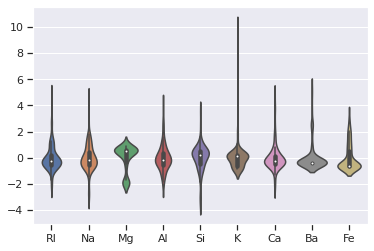

<Figure size 432x288 with 0 Axes>

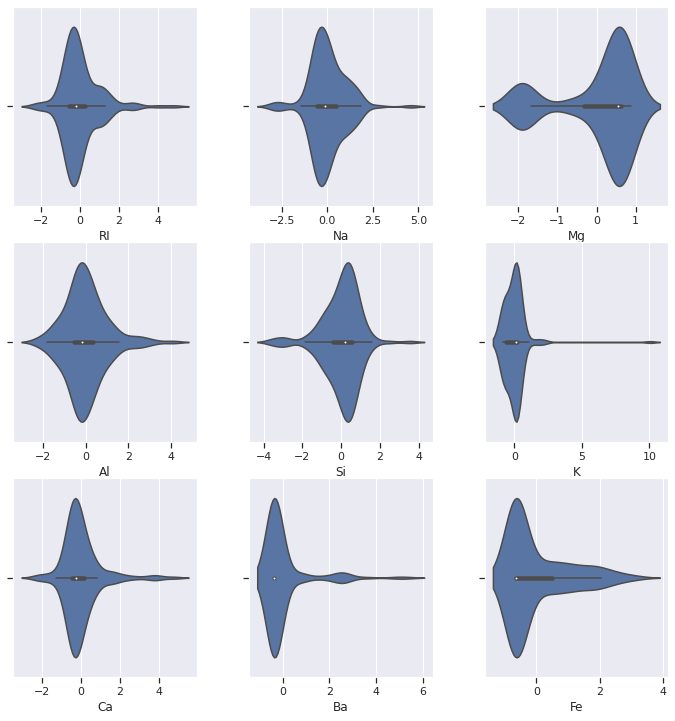

In [125]:

#Violin plot
plt.figure(0)
sns.violinplot(data=normalized_df)

def violin_plot(df,nr=3,nc=3):
    fig,axs = plt.subplots(nrows=nr,ncols=nc, figsize=(10,10))
    fig.tight_layout()
    j = 0
    i = 0
    for feature in df.columns:
        if i % nc == 0 and i != 0:
            j += 1
            i = 0
        sns.violinplot(ax = axs[j,i],x=feature, data=df)
        i += 1

plt.figure(1)
violin_plot(normalized_df)

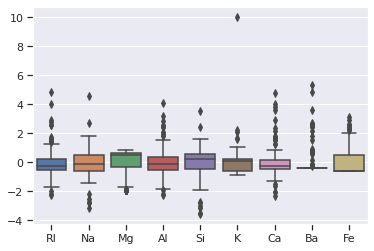

<Figure size 432x288 with 0 Axes>

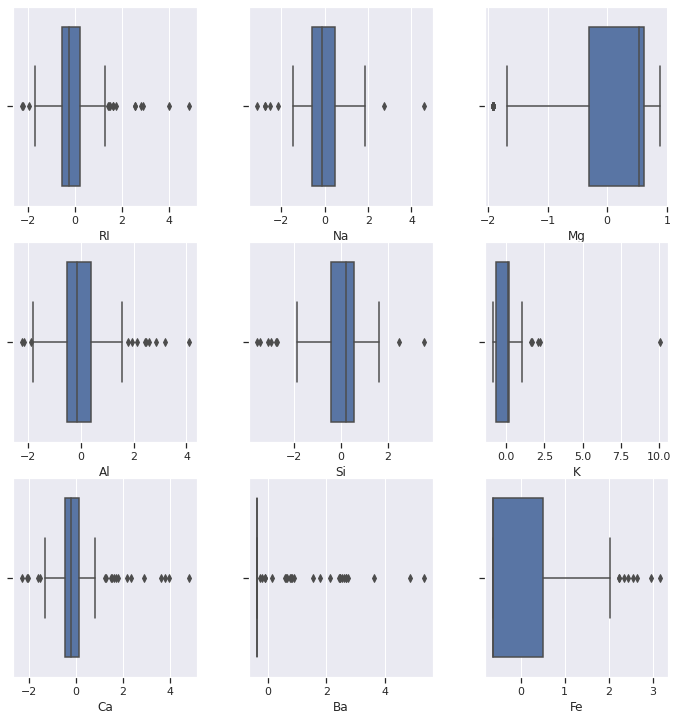

In [126]:
#Boxplot
plt.figure(0)
sns.boxplot(data=normalized_df)

def boxplot(df,nr=3,nc=3):
    fig,axs = plt.subplots(nrows=nr,ncols=nc, figsize=(10,10))
    fig.tight_layout()
    j = 0
    i = 0
    for feature in df.columns:
        if i % nc == 0 and i != 0:
            j += 1
            i = 0
        sns.boxplot(ax = axs[j,i],x=feature, data=df)
        i += 1

plt.figure(1)
boxplot(normalized_df)

/home/king1323/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/king1323/.local/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


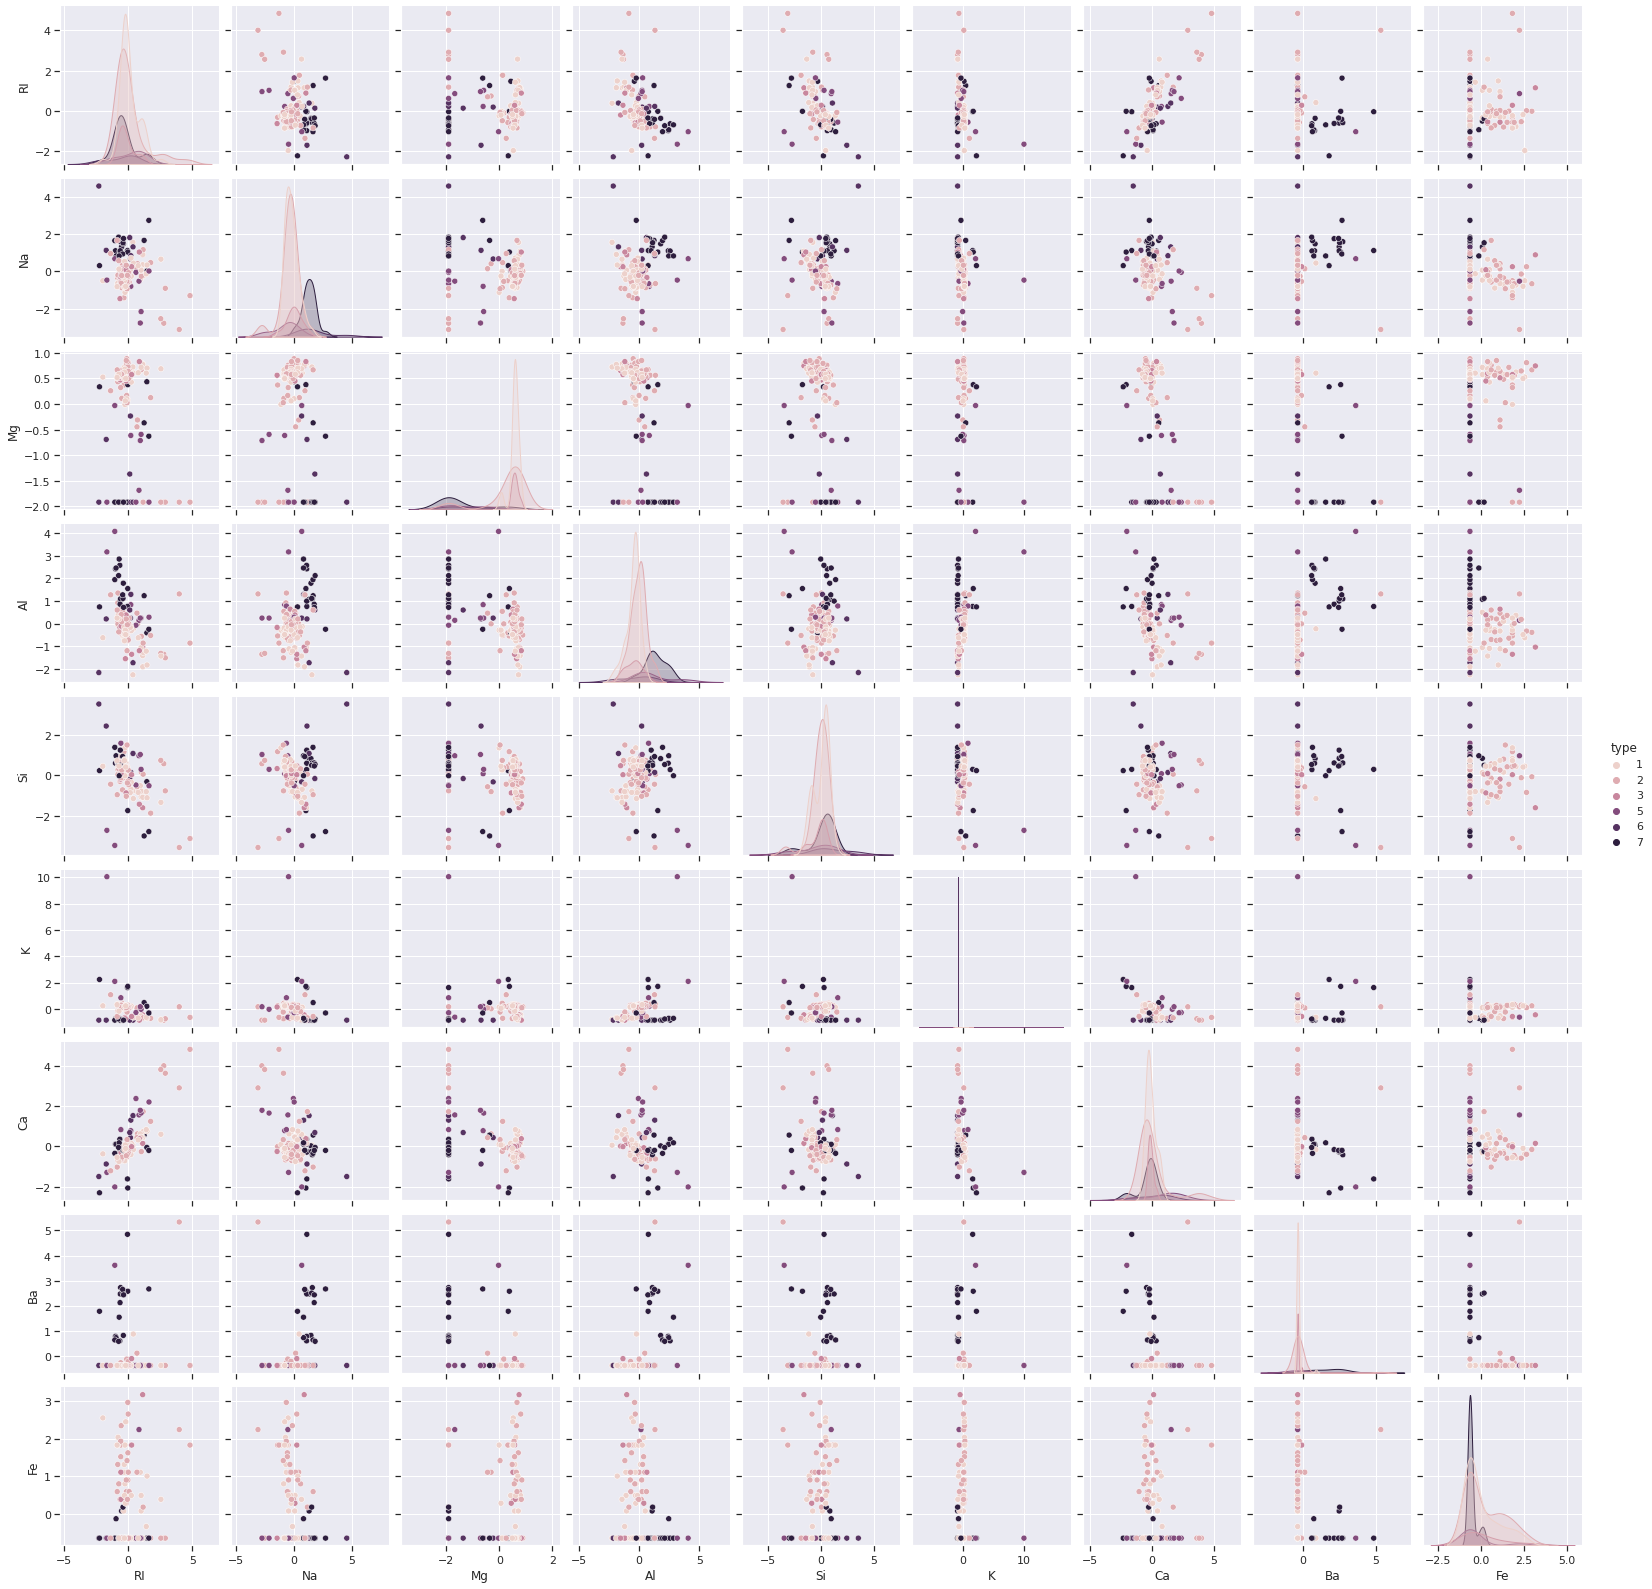

In [129]:
normalized_df['type'] = t
sns.pairplot(normalized_df,vars=normalized_df.columns[:-1],hue='type')

## 03 Custom Implementations
---

## #04 Training and Evaluating Models
---

### Decision Trees
---

### Neural Networks
---

### Ensemble Classifier
---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=300e78d7-19a6-4bf7-a170-13a747371ec7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>